In [1]:
import os,sys,torch
import numpy as np
import cv2
from matplotlib import pyplot as plt
from melanoma.data.dataset import SIIMDataset
from melanoma.config import TRAIN_CSV, IMAGE_DIR, TEST_CSV
dataset = SIIMDataset(IMAGE_DIR, TRAIN_CSV)
import albumentations as A

In [170]:
#
def medium_3(image_size, p=1.0):
    cutout_crop = int(0.25*image_size)
    return A.Compose([
        # RandomCrop(input_size) / RandomResizedCrop (0.08, 1)
        A.HorizontalFlip(p=0.5), # vflip
        A.VerticalFlip(p=0.5), # hflip
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.3),
        A.OneOf([
            A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=1.0, alpha_coef=.1),
            A.ImageCompression(quality_lower=20, quality_upper=99),
        ], p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.125, contrast_limit=0.2, p=0.5), # contrast_limit=0.5
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=30, val_shift_limit=20, p=0.2),
        A.GaussNoise(var_limit=(1, 50), p=0.4),
        A.CoarseDropout(min_holes=1, max_holes=2, max_height=cutout_crop, max_width=cutout_crop, p=0.5),
    ], p=p)

from albumentations.pytorch import ToTensor
image_size=256
test_transform = A.Compose([
    A.SmallestMaxSize(max_size=image_size, always_apply=True),
    medium_3(image_size, p=1.0),
    A.CenterCrop(image_size, image_size, always_apply=True),
    ToTensor(),
])
#print(test_transform)

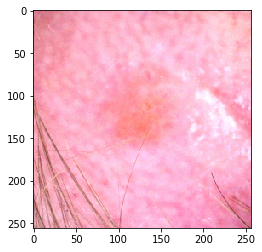

(256, 384, 3) uint8 /mnt/fastdata/kaggle/siim-isic-melanoma-classification/jpeg/train/ISIC_2637011_small.jpg


In [172]:
elem = dataset[0]
img = cv2.cvtColor(elem['image'], cv2.COLOR_BGR2RGB)
#aug = strong_aug(p=1)
aug = test_transform#medium_2(256)
#img = A.HorizontalFlip().apply(img)
new_img = aug(image=img)['image']
if isinstance(new_img, torch.FloatTensor):
    new_img = new_img.permute(1, 2, 0).numpy()
plt.imshow(new_img)
plt.show()
print(img.shape, img.dtype, elem['path'])

(256, 384, 3)
Compose([
  SmallestMaxSize(always_apply=True, p=1, max_size=256, interpolation=1),
  Compose([
    HorizontalFlip(always_apply=False, p=0.5),
    VerticalFlip(always_apply=False, p=0.5),
    ShiftScaleRotate(always_apply=False, p=0.3, shift_limit=(-0.0625, 0.0625), scale_limit=(-0.19999999999999996, 0.19999999999999996), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=None, mask_value=None),
    OneOf([
      RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.3, fog_coef_upper=1.0, alpha_coef=0.1),
      ImageCompression(always_apply=False, p=0.5, quality_lower=20, quality_upper=99, compression_type=0),
    ], p=0.3),
    RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.125, 0.125), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
    HueSaturationValue(always_apply=False, p=0.2, hue_shift_limit=(-5, 5), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
    GaussNoise(always_apply=False, p=0.4, var_limit=(1, 50)),
    Coa

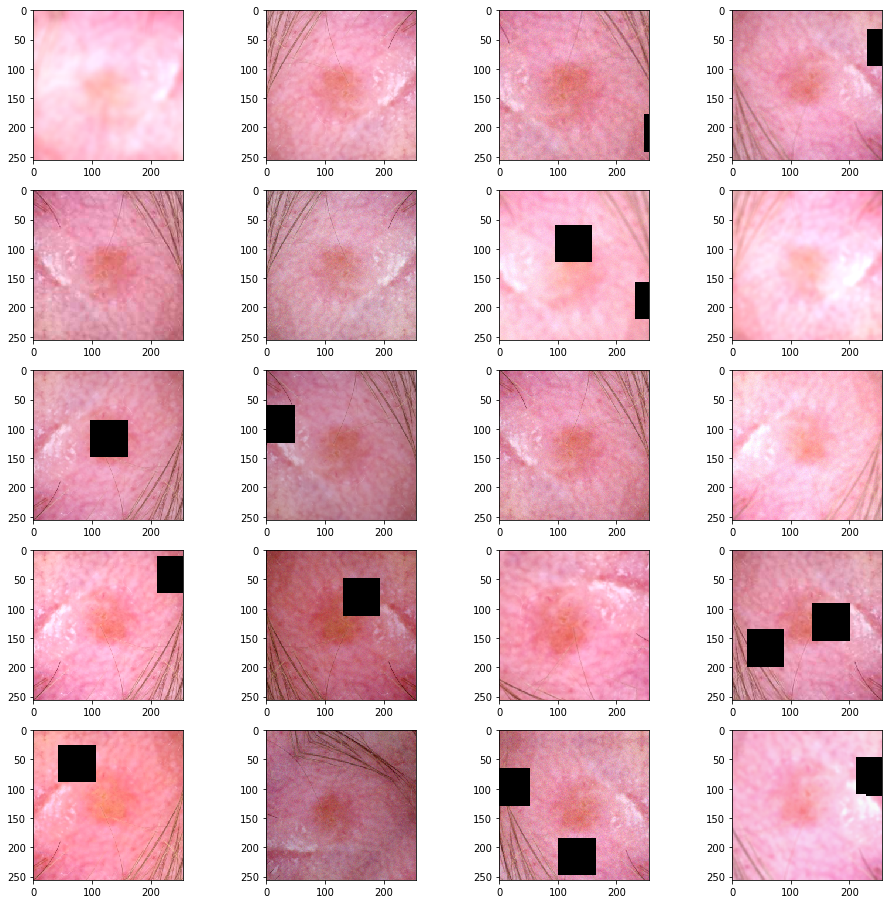

In [173]:
import time
from melanoma.data.transform import factory
elem = dataset[0]
img = cv2.cvtColor(elem['image'], cv2.COLOR_BGR2RGB)
print(img.shape)
#aug = factory('heavy_1', 300, p=1.0, without_norm=True)[0]
aug = test_transform
print(aug)
#aug = strong_aug(p=1)

w, h = 40, 40
columns, rows = 4, 5
fig=plt.figure(figsize=(16, 16))
t1 = time.time()
new_images = [aug(image=img)['image'] for _ in range(columns*rows)]
print('time', time.time()-t1) # 14 m1, 3.9 m2, 36 h1 for 50x (old)
#sys.exit()
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    new_img = new_images[i-1]
    #new_img = aug(img)
    plt.imshow(new_img.permute(1, 2, 0).numpy())
    #print(new_img.shape, np.max(new_img))
    #print(new_img.size(), torch.max(new_img))
plt.show()

In [14]:
# print('Start')
# from melanoma.data.utils import Datasets
#
# ll = Datasets(IMAGE_DIR, TRAIN_CSV, TEST_CSV, transform_name='heavy_1',
#             image_size=300)
# tr = ll.train_dataset
#
# for i, elem in enumerate(tr):
#     if elem['image'] is None:
#         print(elem)
#     if i % 1000 == 0:
#         print(i, len(tr))


